In this post, we'll create a three layer neural net for identifying handwritten numbers; to keep it from overfitting, we'll use a technique known as dropout. First, let's have a look at the data.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import load_digits

digits = load_digits()
digits.images.shape

(1797, 8, 8)

We have 1797 handwritten numbers, each represented by 8x8=64 pixels; here's a plot showing some of them:

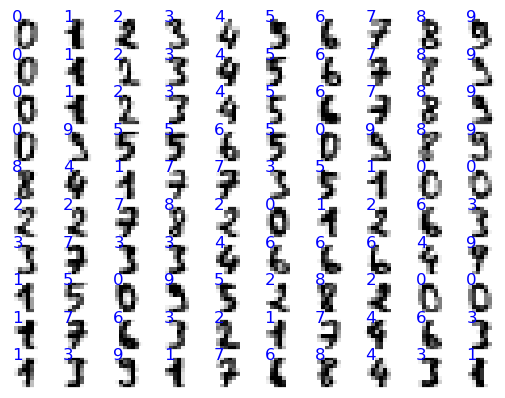

In [9]:
%matplotlib inline
fig, axes = plt.subplots(10,10,subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i],cmap='binary',interpolation='nearest')
    ax.text(0.1,0.2,str(digits.target[i]),color='blue')

For each number, we'll convert its 8x8 matrix of pixel values into an array of length 64; then we'll feed those numbers into layer 0 of our neural net. The next, hidden layer, will contain 200 neurons, and the output layer will contain 10 neurons, the first corresponding to the number 0, the second to 1, and so on up to 9. The output numbers will be "one-hot" encoded so, for example, if the number we feed in is 4 the neural net will ideally output the array [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]. We start by getting our data into the proper form as well as setting up the variables and functions that our neural net will need.

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# normalize the data, hot-one encode the target data; create 
# training and test sets
X = digits.data
y_pre = digits.target
y = np.zeros((y_pre.shape[0],10))
for i in range(y_pre.shape[0]):
    y[i,y_pre[i]]=1.0
X = (X-X.mean())/X.var()
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y)

# initialize weights and layers for a 3 layer neural net
# for which all biases are set to zero
num_inputs   = 64
num_outputs  = 10
hidden_layer = 200
layer_0 = np.zeros((1,num_inputs))
layer_1 = np.zeros((1,hidden_layer))
layer_2 = np.zeros((1,num_outputs))
weights_01 = 2.0*np.random.random((num_inputs,hidden_layer))-1.0
weights_12 = 2.0*np.random.random((hidden_layer,num_outputs))-1.0

# define the relu function and its derivative, which will be 
# applied to the hidden layer only
def relu(x):
    return x*(x > 0)

def relu_deriv(x):
    return 1.0*(x>0)

Now we let the neural net learn from the data but, to keep it from overlearning (that is, memorizing details that are not relevant for detecting the overall patterns), we randomly set half the neurons of the hidden layer to zero before each backpropagation step and we double the other ones to compensate for the missing half of the signal from that layer.

In [13]:
alpha = 0.01
max_iter = 200
err_tol  = 0.1
err = 1000.0
iter = 0
# toggle dropout on or off
dropout = 1
while ((iter<max_iter) & (err>err_tol)):
    err = 0.0
    for i in range(Xtrain.shape[0]):
        layer_0 = Xtrain[i].reshape(1,num_inputs)
        layer_1 = relu(np.matmul(layer_0,weights_01))
        layer_2 = np.matmul(layer_1,weights_12)

        if (dropout == 1):
            dropout_mask = \
                    np.random.randint(0,2,layer_1.shape)
            layer_1 *= 2.0*dropout_mask

        delta = layer_2-ytrain[i]
        gradient_12 = np.outer(layer_1,delta)
        deriv_vec   = relu_deriv(layer_1)
        deriv_diag  = np.diag(deriv_vec.ravel())
        omega = np.matmul(weights_12.T,deriv_diag)
        delta_omega = np.matmul(delta,omega)
        gradient_01 = np.outer(layer_0,delta_omega)

        
        weights_12 -= alpha*gradient_12
        weights_01 -= alpha*gradient_01

        err += np.sum(delta**2.0)
    err /= X.shape[0]
    iter += 1
    
if (iter<max_iter):
    print("converged at iteration: ",iter-1)
    print("average error: ",err)
else:
    print("failed to converge")

converged at iteration:  94
average error:  0.09921353506417917


Now we see how well our model can predict numbers for the test set.

In [14]:
err = 0.0
num_correct = 0
ypred = np.zeros((Xtest.shape[0],10))
for i in range(Xtest.shape[0]):
    layer_0 = Xtest[i].reshape(1,num_inputs)
    layer_1 = relu(np.matmul(layer_0,weights_01))
    layer_2 = np.matmul(layer_1,weights_12)
    ypred[i] = layer_2.round()
    delta = layer_2-ytest[i]
    err += np.sum(delta**2.0)
    if (layer_2.round()==ytest[i]).all():
        num_correct += 1
err /= Xtest.shape[0]
print("average test set error:",err)
frac_correct = num_correct/Xtest.shape[0]
print("percent correct:",frac_correct*100.0)

average test set error: 0.23912728350196497
percent correct: 91.55555555555556


Our neural net predicts about 92% of the test set numbers correctly (also, if we rerun the above code but with the dropout turned off, the model will tend to perform more poorly on the test set). Let's plot the confusion matrix for our current predictions, and set to -1 any output for which the model fails to select a number.

Text(109.44999999999997, 0.5, 'predicted label')

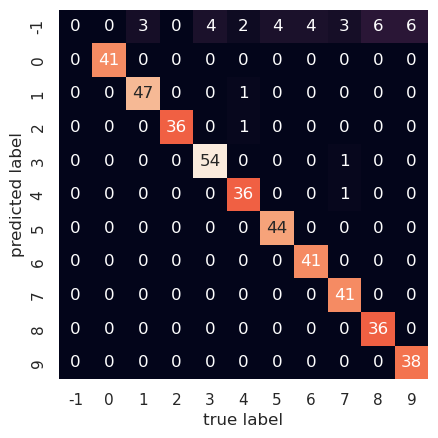

In [15]:
pred_array = np.zeros((1,Xtest.shape[0])).ravel()
test_array = np.zeros((1,Xtest.shape[0])).ravel()
for i in range(Xtest.shape[0]):
    if (ypred[i]==1.0).any():
        pred_array[i] = np.where(ypred[i]==1)[0][0]
    else:
        pred_array[i] = -1
    test_array[i] = np.where(ytest[i]==1)[0][0]

mat = confusion_matrix(test_array,pred_array)
labels = np.linspace(-1,9,11).astype('int64')
sns.heatmap(mat.T, square=True,annot=True, \
            xticklabels=labels, \
            yticklabels=labels, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

We can see, e.g., that 3 times the correct answer is 1, while the model was unable to select any number. On the other hand, it correctly identified 3 as such 54 times. The derivations for the backpropagation equations are instructive but a bit involved, so I'll provide those in the next post.